In [202]:
import os
os.chdir('/lustre/scratch/aylar/scanpy_analysis/')
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [11]:
data = sc.read_text('GSE207422_NSCLC_scRNAseq_UMI_matrix.txt', first_column_names=True)
adata= data.T
print(adata)
print(adata.obs_names[:5])
print(adata.var_names[:5])
print(adata.X[:5, :5])

AnnData object with n_obs × n_vars = 92330 × 24292
Index(['BD_immune01_612637', 'BD_immune01_698718', 'BD_immune01_509246',
       'BD_immune01_101435', 'BD_immune01_400370'],
      dtype='object')
Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1'], dtype='object')
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0.]]


In [12]:
df = pd.DataFrame({'Patient': ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12','P13', 'P14', 'P15'],
'Sex': ['Male', 'Female', 'Male', 'Male', 'Female', 'Female', 'Male', 'Female', 'Male', 'Male', 'Female', 'Male', 'Male', 'Male', 'Male'],
    'Age': [68, 67, 66, 66, 34, 45, 57, 61, 66, 70, 67, 77, 59, 79, 55],
    "Pathology": ["Squamous", "Adeno", "Squamous", "Adeno", "Adeno", "Adeno", "Squamous", "Adeno", "Squamous", "Squamous", "Adeno", "Adeno", "Squamous", "Squamous", "Adeno"],
    "PD1 Antibody": ["Toripalimab", "Toripalimab", "Toripalimab", "Toripalimab", "Toripalimab", "Toripalimab", "Toripalimab", "Camrelizumab", "Sintilimab", "Sintilimab", "Sintilimab", "Sintilimab", "Sintilimab", "Sintilimab", "Sintilimab"],
    "Chemotherapy": ["Carboplatin+Docetaxel", "Carboplatin+Pemetrexed", "Carboplatin+Gemcitabine", "Carboplatin+Pemetrexed", "Carboplatin+Pemetrexed", "Carboplatin+Pemetrexed", "Carboplatin+Gemcitabine", "Carboplatin+Pemetrexed", "Carboplatin+Gemcitabine", "Carboplatin+Gemcitabine", "Carboplatin+Pemetrexed", "Carboplatin+Pemetrexed", "Carboplatin+Gemcitabine", "Carboplatin+Gemcitabine", "Carboplatin+Pemetrexed"],
    "Pathologic Response": ["NE", "NMPR", "MPR", "NMPR", "NMPR", "pCR", "NMPR", "NMPR", "NMPR", "NMPR", "MPR", "NMPR", "NMPR", "MPR", "NMPR"],
    "Residual Tumor": ["NE", "80%", "5%", "20%", "78%", "0%", "90%", "95%", "95%", "70%", "9%", "80%", "40%", "1%", "95%"],
    "RECIST": ["SD", "PR", "PR", "PR", "PR", "PR", "SD", "SD", "PR", "PR", "SD", "SD", "PR", "PR", "SD"]}, index=['BD_immune01', 'BD_immune02', 'BD_immune03', 'BD_immune04', 'BD_immune05', 'BD_immune06', 'BD_immune07', 'BD_immune08', 'BD_immune09', 'BD_immune10', 'BD_immune11', 'BD_immune12', 'BD_immune13', 'BD_immune14', 'BD_immune15'])

In [13]:
# Extract the sample name part (before the second underscore) from adata.obs.index
adata.obs['Sample'] = adata.obs.index.str.split('_').str[0] + '_' + adata.obs.index.str.split('_').str[1]

# Now merge adata.obs with df, matching on the 'Sample' in adata.obs and the index of df
adata.obs = adata.obs.merge(df[['Patient','Sex', 'Age', 'Pathology', 'PD1 Antibody','Chemotherapy', 'Pathologic Response', 'Residual Tumor', 'RECIST' ]], left_on='Sample', right_index=True, how='left')


In [14]:
adata.obs.columns

Index(['Sample', 'Patient', 'Sex', 'Age', 'Pathology', 'PD1 Antibody',
       'Chemotherapy', 'Pathologic Response', 'Residual Tumor', 'RECIST'],
      dtype='object')

In [15]:
adata.obs.head()

Sample Patient   Sex  Age Pathology PD1 Antibody  \
BD_immune01_612637  BD_immune01     P01  Male   68  Squamous  Toripalimab   
BD_immune01_698718  BD_immune01     P01  Male   68  Squamous  Toripalimab   
BD_immune01_509246  BD_immune01     P01  Male   68  Squamous  Toripalimab   
BD_immune01_101435  BD_immune01     P01  Male   68  Squamous  Toripalimab   
BD_immune01_400370  BD_immune01     P01  Male   68  Squamous  Toripalimab   

                             Chemotherapy Pathologic Response Residual Tumor  \
BD_immune01_612637  Carboplatin+Docetaxel                  NE             NE   
BD_immune01_698718  Carboplatin+Docetaxel                  NE             NE   
BD_immune01_509246  Carboplatin+Docetaxel                  NE             NE   
BD_immune01_101435  Carboplatin+Docetaxel                  NE             NE   
BD_immune01_400370  Carboplatin+Docetaxel                  NE             NE   

                   RECIST  
BD_immune01_612637     SD  
BD_immune01_698718     SD  
BD_immune01_509246     SD  
BD_immune01_101435     SD  
BD_immune01_400370     SD

In [16]:
# Step 1: QC - Exclude cells with < 500 expressed genes
adata.obs['n_genes'] = np.count_nonzero(adata.X, axis=1).flatten()
adata = adata[adata.obs['n_genes'] > 500, :]
# Step 2: QC - Exclude cells with > 20% UMIs of mitochondrial genes
# Identify mitochondrial genes (assuming they start with "MT-")
mito_genes = [gene for gene in adata.var_names if gene.startswith('MT-')]
adata.obs['total_counts'] = np.array(adata.X.sum(axis=1)).flatten()  # Total counts per cell
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / adata.obs['total_counts']
adata = adata[adata.obs['percent_mito'] < 0.2, :]  # Filter cells with > 20% mitochondrial genes
# Step 3: QC - Exclude cells with > 50% UMIs of ribosomal genes
# Identify ribosomal genes (assuming they start with "RPS" or "RPL")
ribosomal_genes = [gene for gene in adata.var_names if gene.startswith('RPS') or gene.startswith('RPL')]
adata.obs['percent_ribo'] = np.sum(adata[:, ribosomal_genes].X, axis=1) / adata.obs['total_counts']
adata = adata[adata.obs['percent_ribo'] < 0.5, :]

In [17]:
adata.write('QC_GSE207422.h5ad')

In [203]:
adata=sc.read('QC_GSE207422.h5ad')

In [204]:
# Normalize total counts to 10,000 per cell
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat')

marker_genes = ["EPCAM", "COL1A1", "VWF", "CD3E", "CD79A", "MS4A1", "IGHG1",
               "CSF3R", "LYZ", "FGFBP2", "KIT", "LILRA4", "MKI67","PTPRC","C1orf194", "RSPH1", "C9orf24", "CAPS", "TPPP3", "SLPI","SCGB1A1",
"SCGB3A1", "MSMB", "BPIFB1", "GJB6", "MYH11", "AL365357.1", "SERPINB9", "IL1R2",
"SPARCL1", "NAPSA", "SCGB3A2", "SFTPB", "SFTPA1","SFTPA2", "SMC4", "ARL6IP1",
"CENPF","TPX2", "TOP2A", "DUT","RRM2","HIST1H2BJ","TYMS", "PCNA","IGKC","MT2A",
"S100A9","KRT81","S100P","PI3","KLK10","LY6G6C","CEACAM5","KRT16","NDUFA4L2","AKR1B10","NMRAL2P","ALDH3A1", "DST"]
# Identify missing marker genes
missing_markers = [gene for gene in marker_genes if gene not in adata.var_names]
if missing_markers:
    print(f"Warning: The following marker genes are not in the dataset and will be ignored:\n{missing_markers}")

# Ensure marker genes are retained in HVGs
adata.var["highly_variable"] = adata.var["highly_variable"] | adata.var_names.isin(marker_genes)

# Subset the AnnData object to keep only highly variable genes (including forced markers)
adata = adata[:, adata.var["highly_variable"]]

# Verify which marker genes were successfully retained
retained_markers = [gene for gene in marker_genes if gene in adata.var_names]
print(f"Retained marker genes: {len(retained_markers)} / {len(marker_genes)}")
print(retained_markers)



Retained marker genes: 60 / 60
['EPCAM', 'COL1A1', 'VWF', 'CD3E', 'CD79A', 'MS4A1', 'IGHG1', 'CSF3R', 'LYZ', 'FGFBP2', 'KIT', 'LILRA4', 'MKI67', 'PTPRC', 'C1orf194', 'RSPH1', 'C9orf24', 'CAPS', 'TPPP3', 'SLPI', 'SCGB1A1', 'SCGB3A1', 'MSMB', 'BPIFB1', 'GJB6', 'MYH11', 'AL365357.1', 'SERPINB9', 'IL1R2', 'SPARCL1', 'NAPSA', 'SCGB3A2', 'SFTPB', 'SFTPA1', 'SFTPA2', 'SMC4', 'ARL6IP1', 'CENPF', 'TPX2', 'TOP2A', 'DUT', 'RRM2', 'HIST1H2BJ', 'TYMS', 'PCNA', 'IGKC', 'MT2A', 'S100A9', 'KRT81', 'S100P', 'PI3', 'KLK10', 'LY6G6C', 'CEACAM5', 'KRT16', 'NDUFA4L2', 'AKR1B10', 'NMRAL2P', 'ALDH3A1', 'DST']


In [205]:
# PCA & neighbors
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)
sc.tl.umap(adata)

In [209]:
sc.tl.leiden(adata, resolution=0.08)
# Count total Leiden clusters
num_clusters = len(adata.obs['leiden'].unique())
print(f"Number of Leiden clusters: {num_clusters}")

Number of Leiden clusters: 10


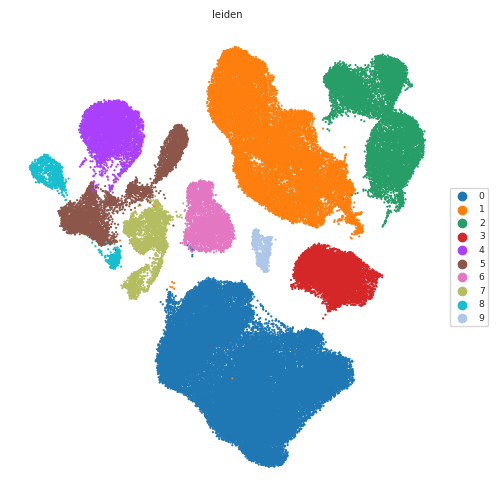

In [210]:
fig, ax = plt.subplots(figsize=(5, 5))  # Set figure size
sc.pl.umap(adata, color="leiden", size=10, frameon=False, ax=ax, show=False)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("leiden_GSE207422.png", dpi=300)
plt.show()

In [211]:
adata.write("leiden_GSE207422.h5ad")

categories: 0, 1, 2, etc.
var_group_labels: Epithelial, Fibroblasts, Endothelial, etc.


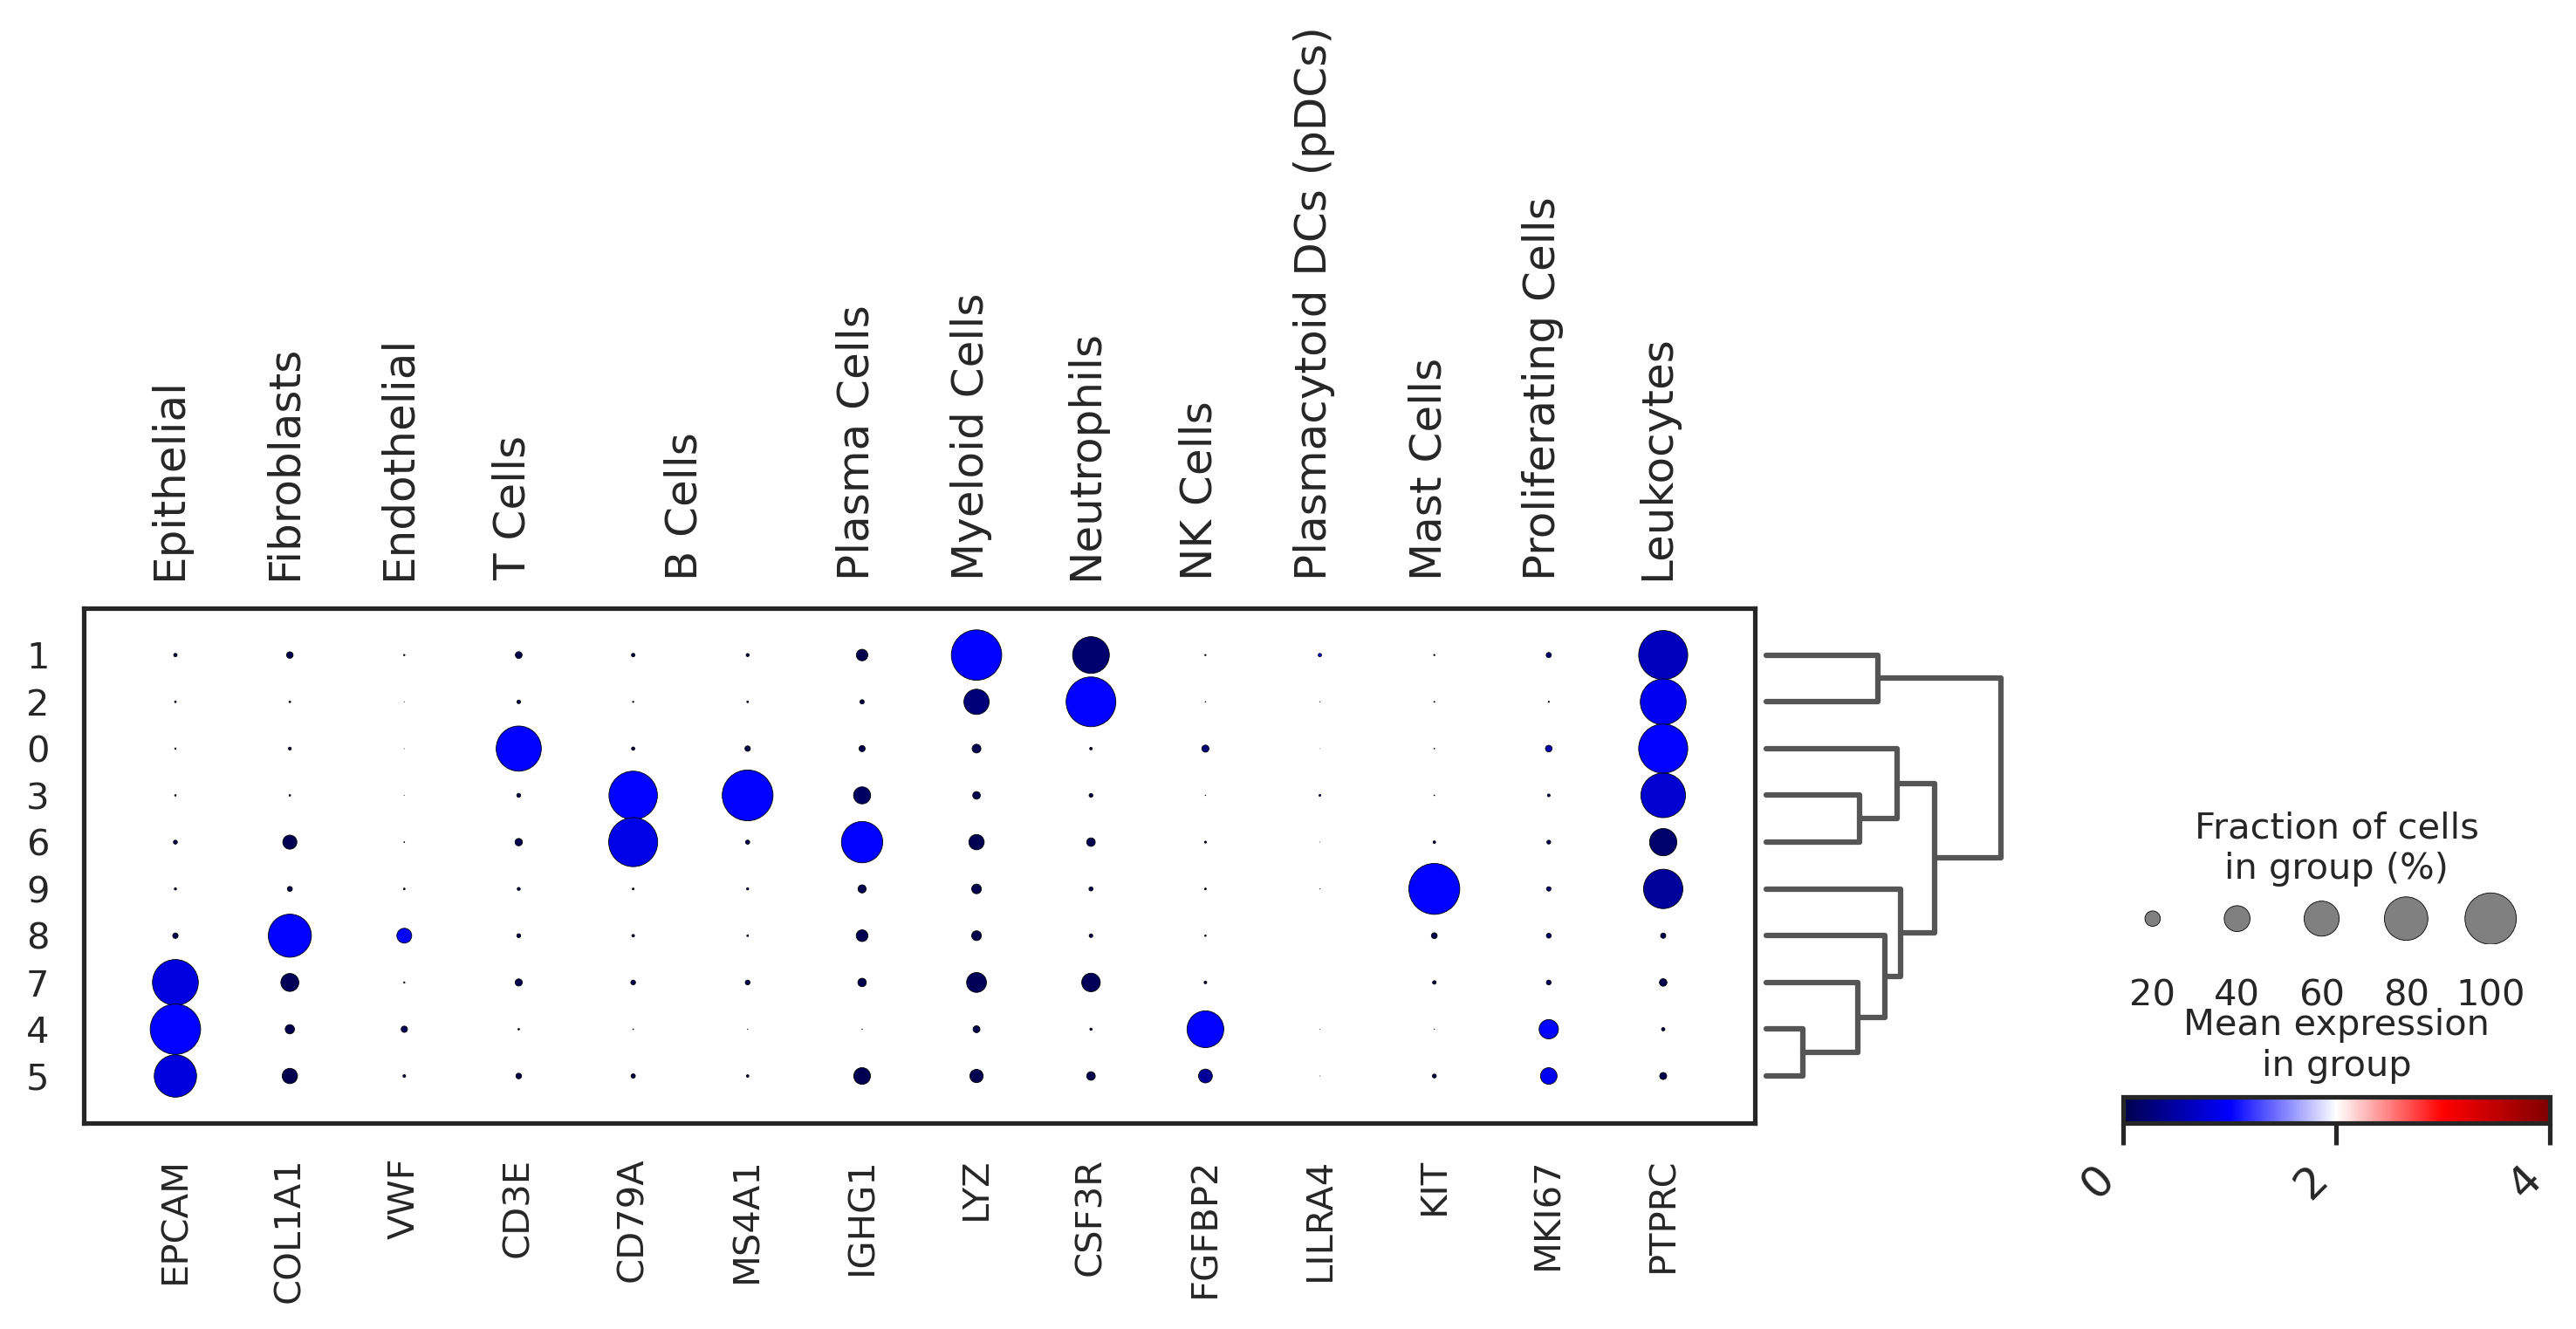

In [212]:
cell_markers = {
    "Epithelial": ["EPCAM"],
    "Fibroblasts": ["COL1A1"],
    "Endothelial": ["VWF"],
    "T Cells": ["CD3E"],
    "B Cells": ["CD79A", "MS4A1"],
    "Plasma Cells": ["IGHG1"],
    "Myeloid Cells": ["LYZ"],
    "Neutrophils": ["CSF3R"],
    "NK Cells": ["FGFBP2"],
    "Plasmacytoid DCs (pDCs)": ["LILRA4"],
    "Mast Cells": ["KIT"],
    "Proliferating Cells": ["MKI67"],
    "Leukocytes": ["PTPRC"]  # CD45 for all hematopoietic cells
}

sns.set_theme(style='white', font_scale=1) 
sc.tl.dendrogram(adata, groupby='leiden')
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)  
sc.pl.dotplot(adata, var_names=cell_markers,  groupby='leiden',  dendrogram=True,  log=False, swap_axes=False,  vmax=4,  ax=ax, 
    cmap="seismic",  dot_max=1,  standard_scale="var",  show=False)


ax.set_xlabel("Marker Genes", fontsize=14, fontweight='bold')
ax.set_ylabel("Leiden Clusters", fontsize=14, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("dotplot.png", dpi=300)
plt.show()


In [213]:
cluster_to_cell = {
    0: "T Cells",
    1: "Myeloid Cells",
    2: "Neutrophils",
    3: "B Cells",
    4: "Epithelial",
    5: "Epithelial",
    6: "B Cells",
    7: "Epithelial",
    8: "Fibroblasts",
    9: "Mast Cells"
    
    
}

adata.obs['leiden'] = adata.obs['leiden'].astype(int)
adata.obs['cell'] = adata.obs['leiden'].map(cluster_to_cell)
adata.obs[['leiden', 'cell']].head()

leiden        cell
BD_immune01_612637       5  Epithelial
BD_immune01_698718       5  Epithelial
BD_immune01_509246       5  Epithelial
BD_immune01_101435       5  Epithelial
BD_immune01_400370       0     T Cells

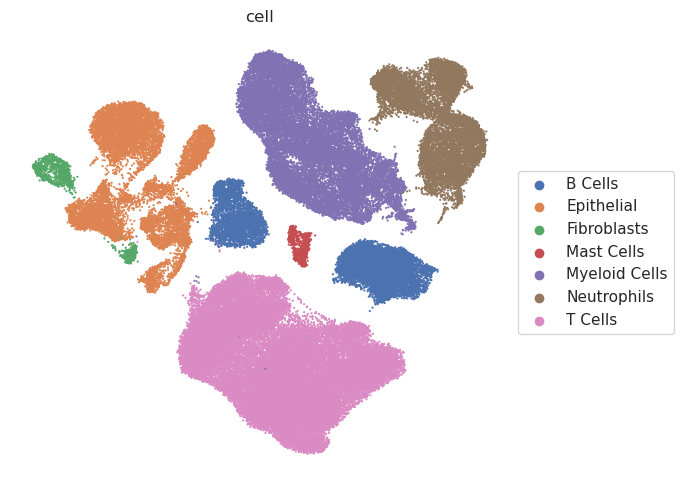

In [214]:
fig, ax = plt.subplots(figsize=(7, 5))  # Set figure size
sc.pl.umap(adata, color=["cell"], size=10, frameon=False,ax=ax,  show=False)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("cell_GSE207422.png", dpi=300)
plt.show()

In [215]:
adata.write("cell_GSE207422.h5ad")

In [216]:
adata=sc.read("cell_GSE207422.h5ad")

In [217]:
adata = adata[adata.obs['cell'] == 'Epithelial'].copy()

In [218]:
adata.obs["cell"].unique

<bound method Series.unique of BD_immune01_612637    Epithelial
BD_immune01_698718    Epithelial
BD_immune01_509246    Epithelial
BD_immune01_101435    Epithelial
BD_immune01_216465    Epithelial
                         ...    
BD_immune07_878198    Epithelial
BD_immune07_696251    Epithelial
BD_immune11_594190    Epithelial
BD_immune11_859437    Epithelial
BD_immune12_862836    Epithelial
Name: cell, Length: 11849, dtype: category
Categories (1, object): ['Epithelial']>

In [219]:
adata.obs.head()

Sample Patient   Sex  Age Pathology PD1 Antibody  \
BD_immune01_612637  BD_immune01     P01  Male   68  Squamous  Toripalimab   
BD_immune01_698718  BD_immune01     P01  Male   68  Squamous  Toripalimab   
BD_immune01_509246  BD_immune01     P01  Male   68  Squamous  Toripalimab   
BD_immune01_101435  BD_immune01     P01  Male   68  Squamous  Toripalimab   
BD_immune01_216465  BD_immune01     P01  Male   68  Squamous  Toripalimab   

                             Chemotherapy Pathologic Response Residual Tumor  \
BD_immune01_612637  Carboplatin+Docetaxel                  NE             NE   
BD_immune01_698718  Carboplatin+Docetaxel                  NE             NE   
BD_immune01_509246  Carboplatin+Docetaxel                  NE             NE   
BD_immune01_101435  Carboplatin+Docetaxel                  NE             NE   
BD_immune01_216465  Carboplatin+Docetaxel                  NE             NE   

                   RECIST  n_genes  total_counts  percent_mito  percent_ribo  \
BD_immune01_612637     SD     7202       45924.0      0.066675      0.110596   
BD_immune01_698718     SD     7356       41596.0      0.042504      0.133498   
BD_immune01_509246     SD     6346       31883.0      0.170153      0.062228   
BD_immune01_101435     SD     6632       31458.0      0.069871      0.087927   
BD_immune01_216465     SD     2552        4737.0      0.001267      0.077897   

                    leiden        cell  
BD_immune01_612637       5  Epithelial  
BD_immune01_698718       5  Epithelial  
BD_immune01_509246       5  Epithelial  
BD_immune01_101435       5  Epithelial  
BD_immune01_216465       5  Epithelial

In [220]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat')

marker_epi= ["C1orf194", "RSPH1", "C9orf24", "CAPS", "TPPP3", "SLPI","SCGB1A1",
"SCGB3A1", "MSMB", "BPIFB1", "GJB6", "MYH11", "AL365357.1", "SERPINB9", "IL1R2",
"SPARCL1", "NAPSA", "SCGB3A2", "SFTPB", "SFTPA1","SFTPA2", "SMC4", "ARL6IP1",
"CENPF","TPX2", "TOP2A", "DUT","RRM2","HIST1H2BJ","TYMS", "PCNA","IGKC","MT2A",
"S100A9","KRT81","S100P","PI3","KLK10","LY6G6C","CEACAM5","KRT16","NDUFA4L2","AKR1B10","NMRAL2P","ALDH3A1", "DST"]
# Identify missing marker genes
missing_markers = [gene for gene in marker_epi if gene not in adata.var_names]
if missing_markers:
    print(f"Warning: The following marker genes are not in the dataset and will be ignored:\n{missing_markers}")

# Ensure marker genes are retained in HVGs
adata.var["highly_variable"] = adata.var["highly_variable"] | adata.var_names.isin(marker_epi)

# Subset the AnnData object to keep only highly variable genes (including forced markers)
adata = adata[:, adata.var["highly_variable"]]

# Verify which marker genes were successfully retained
retained_markers = [gene for gene in marker_epi if gene in adata.var_names]
print(f"Retained marker genes: {len(retained_markers)} / {len(marker_epi)}")
print(retained_markers)

sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)

Retained marker genes: 46 / 46
['C1orf194', 'RSPH1', 'C9orf24', 'CAPS', 'TPPP3', 'SLPI', 'SCGB1A1', 'SCGB3A1', 'MSMB', 'BPIFB1', 'GJB6', 'MYH11', 'AL365357.1', 'SERPINB9', 'IL1R2', 'SPARCL1', 'NAPSA', 'SCGB3A2', 'SFTPB', 'SFTPA1', 'SFTPA2', 'SMC4', 'ARL6IP1', 'CENPF', 'TPX2', 'TOP2A', 'DUT', 'RRM2', 'HIST1H2BJ', 'TYMS', 'PCNA', 'IGKC', 'MT2A', 'S100A9', 'KRT81', 'S100P', 'PI3', 'KLK10', 'LY6G6C', 'CEACAM5', 'KRT16', 'NDUFA4L2', 'AKR1B10', 'NMRAL2P', 'ALDH3A1', 'DST']


In [229]:
sc.tl.leiden(adata, resolution=0.2)
num_clusters = len(adata.obs['leiden'].unique())
print(f"Number of Leiden clusters: {num_clusters}")

Number of Leiden clusters: 11


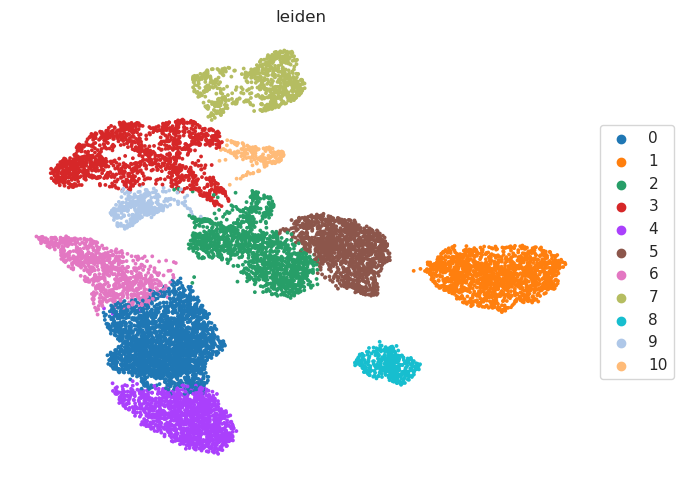

In [230]:
fig, ax = plt.subplots(figsize=(7, 5))  # Set figure size
sc.pl.umap(adata, color=["leiden"], size=30, frameon=False,ax=ax, show=False)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("leiden2_GSE207422.png", dpi=300)
plt.show()

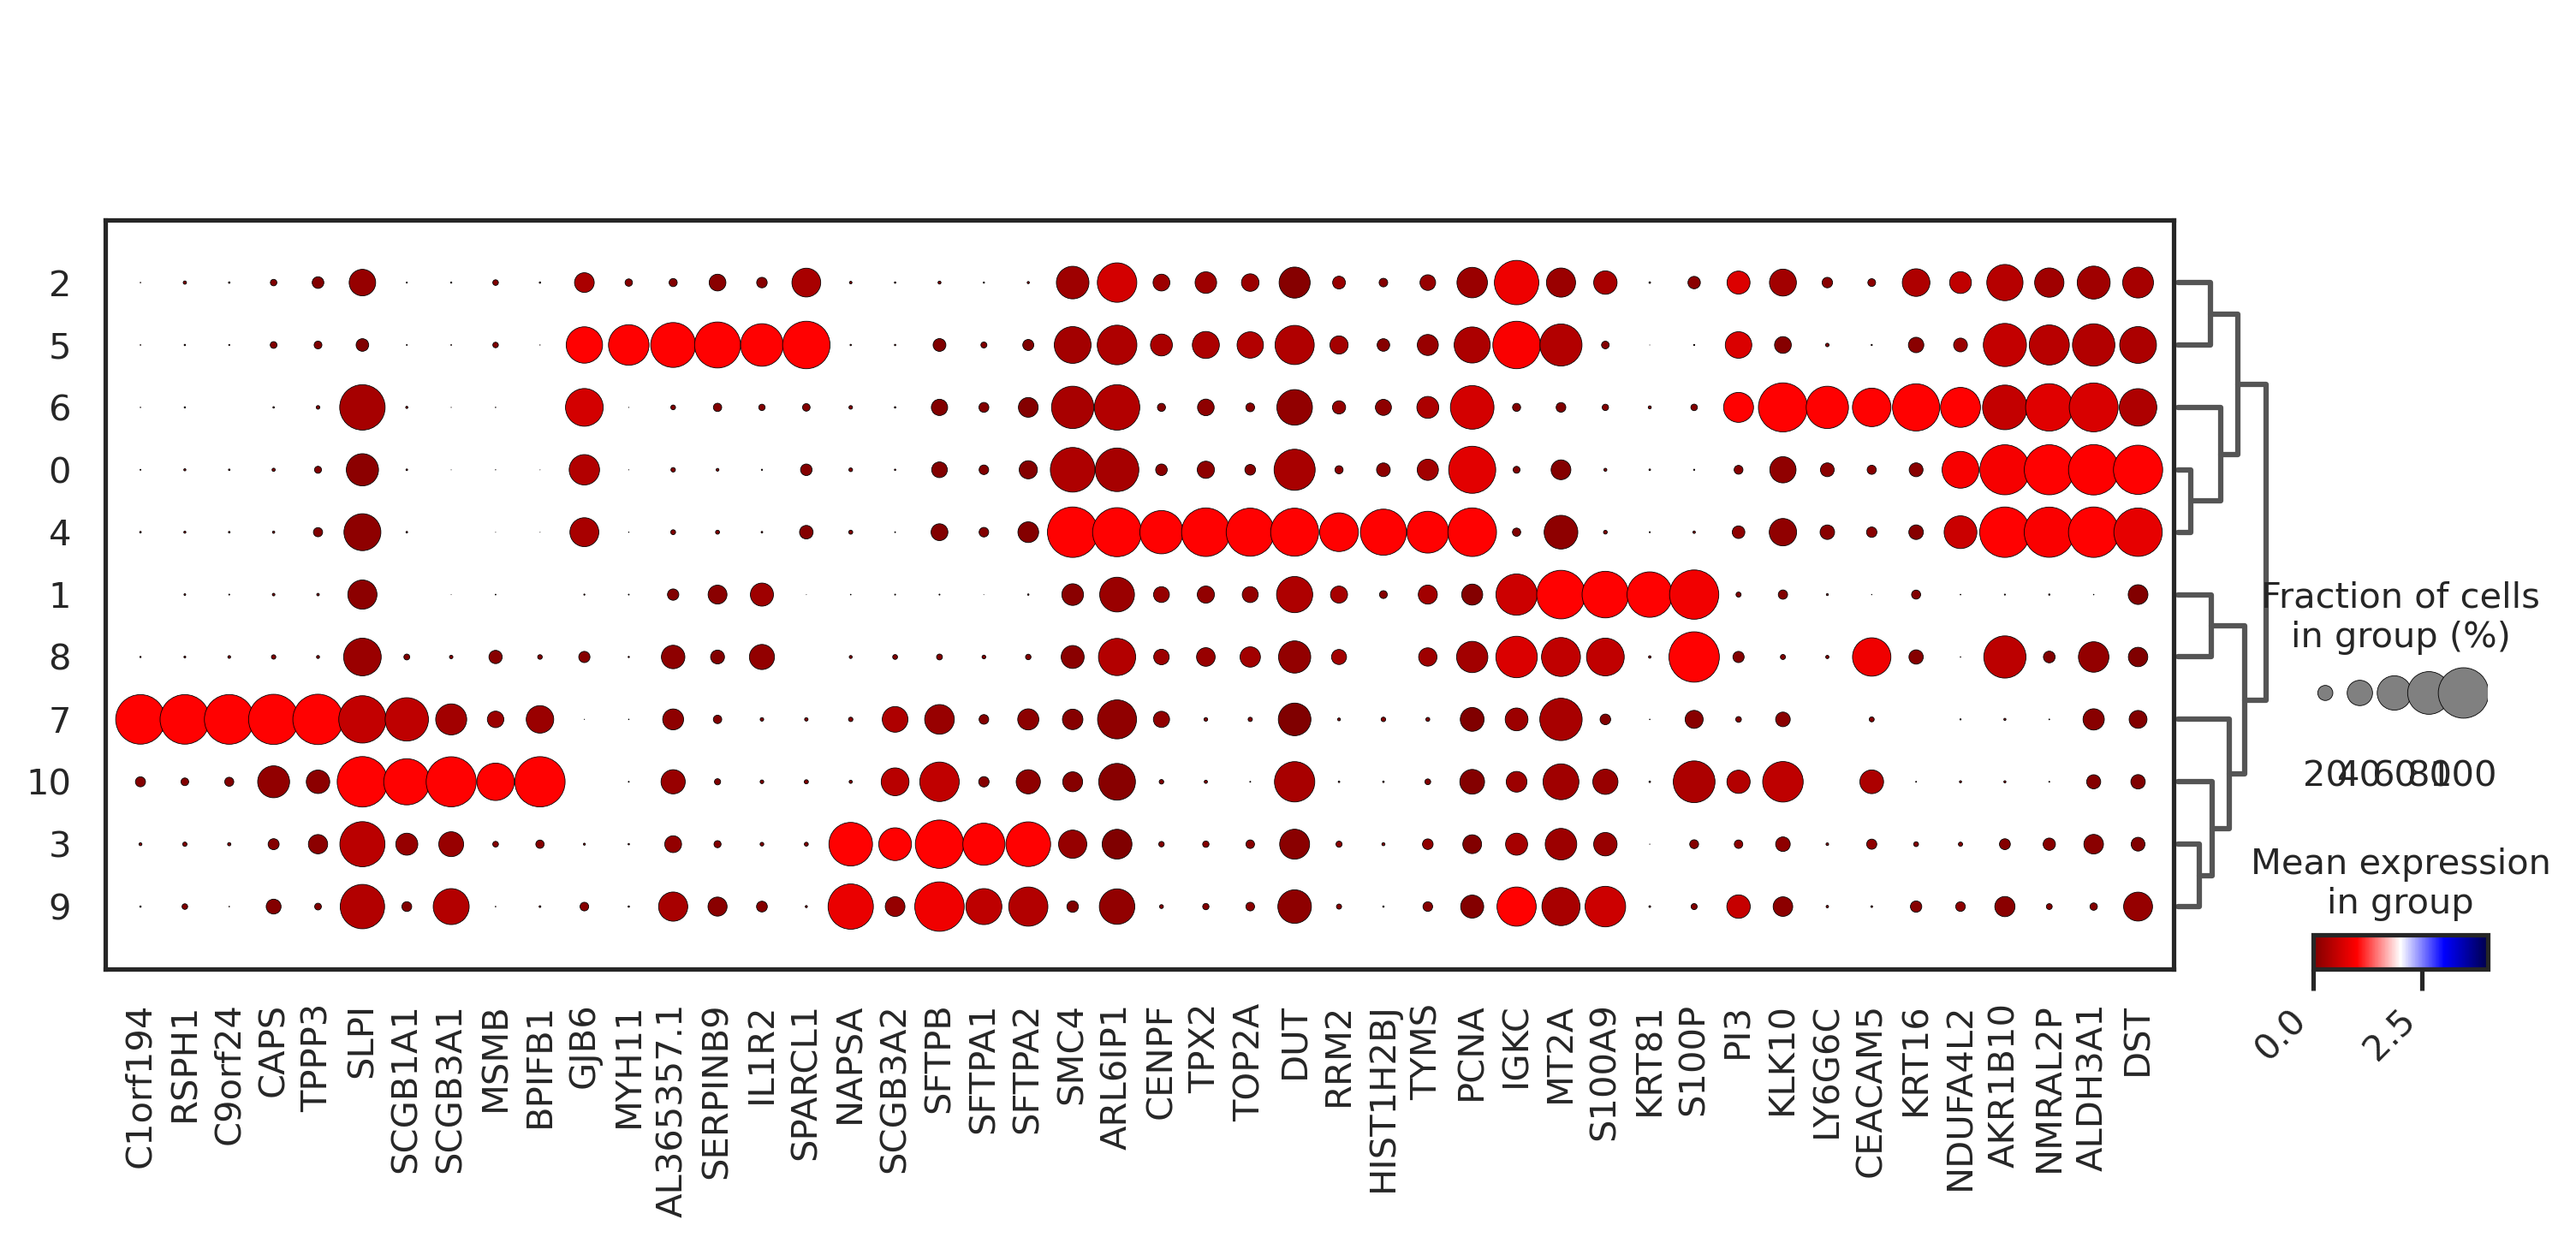

In [240]:
sns.set_theme(style='white', font_scale=1) 
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sc.tl.dendrogram(adata,groupby='leiden')
sc.pl.dotplot(adata,  marker_epi, groupby='leiden', dendrogram=True,  log=False, swap_axes=False,  vmax=4,  ax=ax, 
    cmap="seismic_r",   standard_scale="var",  show=False)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12) 
plt.tight_layout()
plt.savefig("dotplot2_suptype.png", dpi=300)
plt.show()

In [241]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')


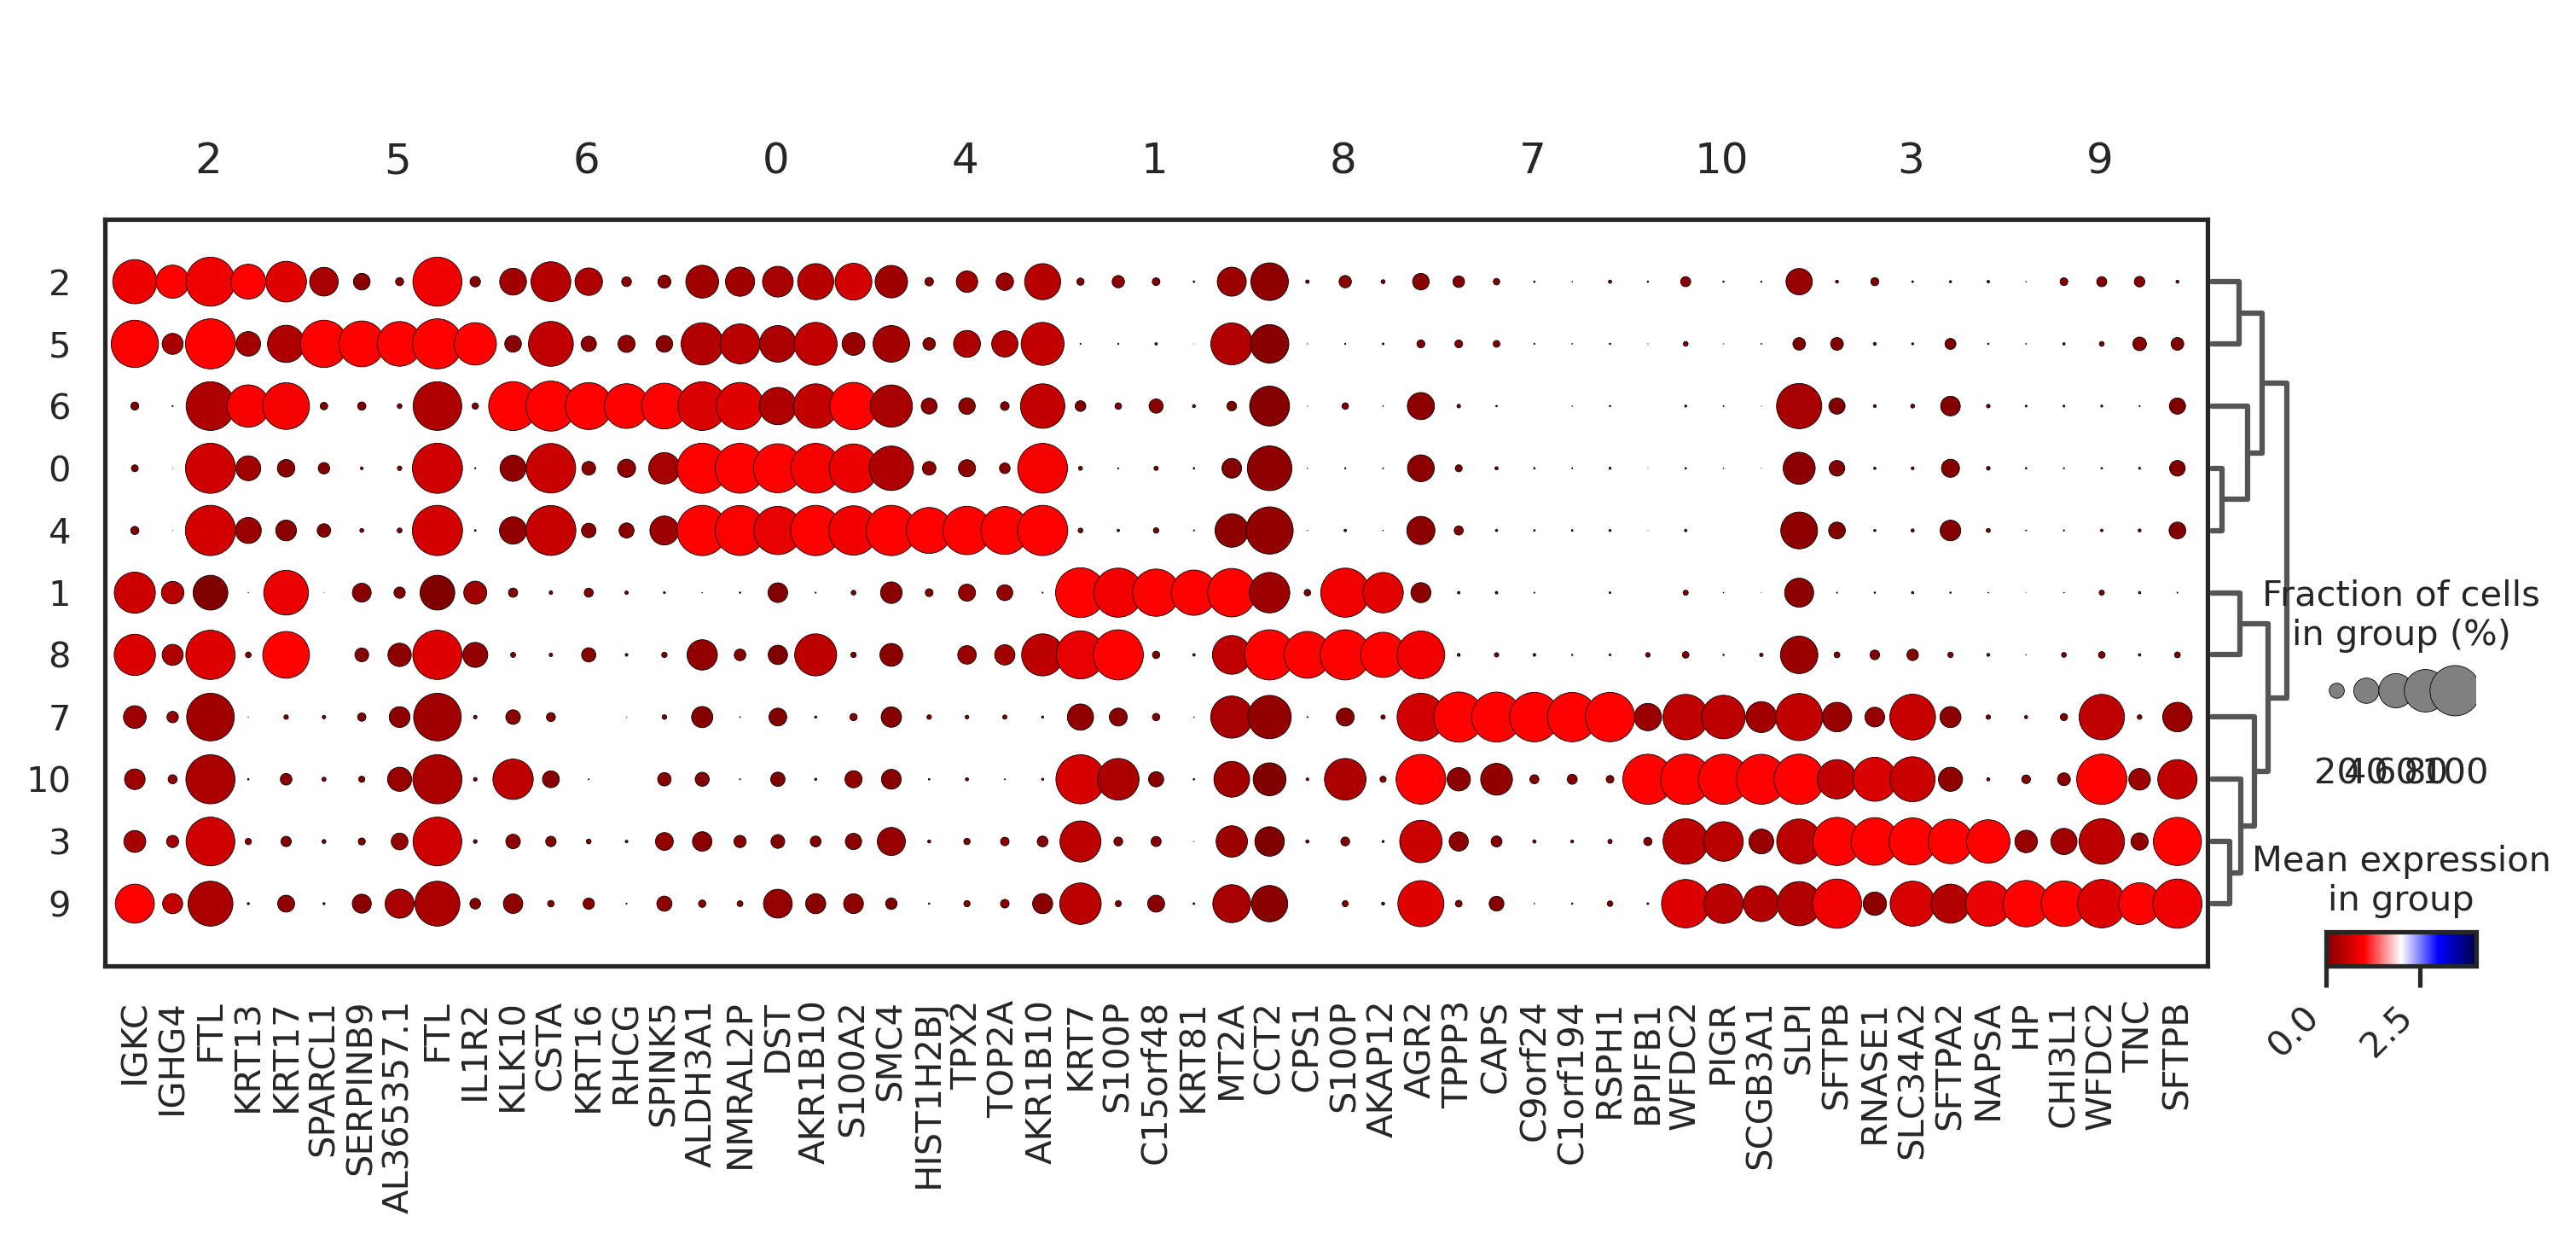

In [244]:
sns.set_theme(style='white', font_scale=1) 
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sc.tl.dendrogram(adata,groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata,  groupby='leiden', n_genes=5, dendrogram=True,  log=False, swap_axes=False,  vmax=4,  ax=ax, 
    cmap="seismic_r",   standard_scale="var",  show=False)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12) 
plt.tight_layout()
plt.savefig("dotplot_suptype.png", dpi=300)
plt.show()

In [245]:
ranked_genes = adata.uns['rank_genes_groups']
top_genes = {}
for cluster in ranked_genes['names'].dtype.names:  
    top_genes[cluster] = ranked_genes['names'][cluster][:5]  
for cluster, genes in top_genes.items():
    print(f"Cluster {cluster}: {', '.join(genes)}")


Cluster 0: ALDH3A1, NMRAL2P, DST, AKR1B10, S100A2
Cluster 1: KRT7, S100P, C15orf48, KRT81, MT2A
Cluster 2: IGKC, IGHG4, FTL, KRT13, KRT17
Cluster 3: SFTPB, RNASE1, SLC34A2, SFTPA2, NAPSA
Cluster 4: SMC4, HIST1H2BJ, TPX2, TOP2A, AKR1B10
Cluster 5: SPARCL1, SERPINB9, AL365357.1, FTL, IL1R2
Cluster 6: KLK10, CSTA, KRT16, RHCG, SPINK5
Cluster 7: TPPP3, CAPS, C9orf24, C1orf194, RSPH1
Cluster 8: CCT2, CPS1, S100P, AKAP12, AGR2
Cluster 9: HP, CHI3L1, WFDC2, TNC, SFTPB
Cluster 10: BPIFB1, WFDC2, PIGR, SCGB3A1, SLPI


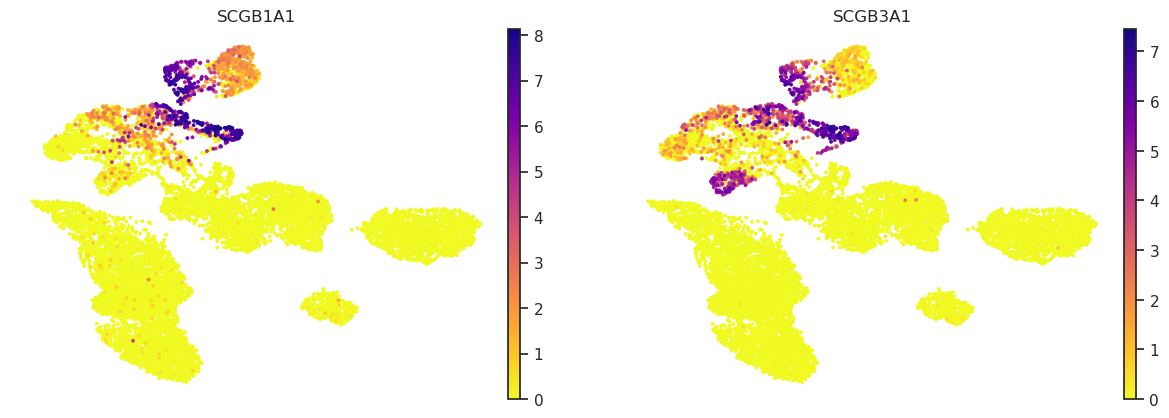

In [246]:
sc.pl.umap(adata, color=["SCGB1A1", "SFTPB", "SFTPA1", "SFTPA2", "SFTPD", "WFDC2", "SLC34A2"], size=30, frameon=False, show=False, cmap="plasma_r")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("club_GSE207422.png", dpi=300)
plt.show()

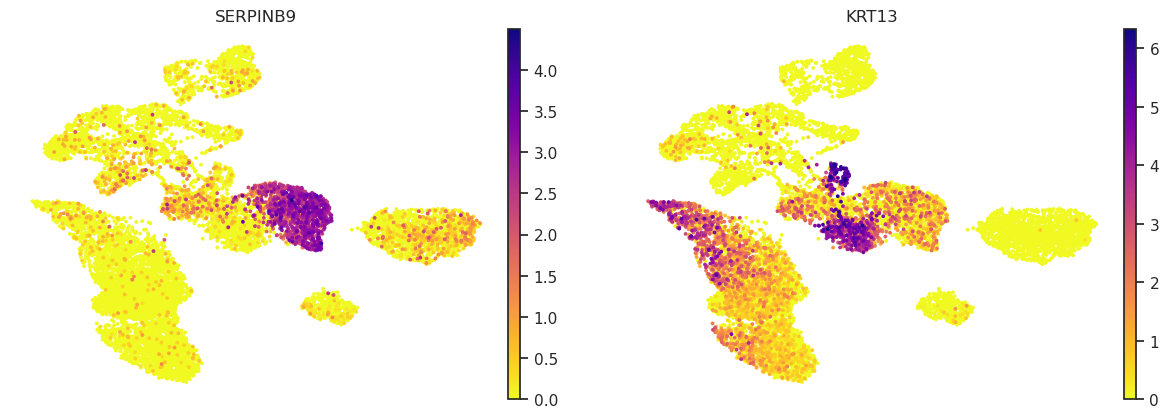

In [252]:
sc.pl.umap(adata, color=["SERPINB9", "KRT13"], size=30, frameon=False, show=False, cmap="plasma_r")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("club_GSE207422.png", dpi=300)
plt.show()

In [255]:
cluster_to_epithelial = {
    0: "Basal",  
    1: "Goblet",
    2: "Hillock",
    3: "Club",  
    4: "Basal",
    5: "Hillock",
    6: "Basal",
    7: "Club",
    8: "Luminal",
    9: "Club",
    10: "Club"
}

adata.obs['leiden'] = adata.obs['leiden'].astype(int)
adata.obs['epithelial'] = adata.obs['leiden'].map(cluster_to_epithelial)
adata.obs[['leiden', 'epithelial']].head()

leiden epithelial
BD_immune01_612637       2    Hillock
BD_immune01_698718       2    Hillock
BD_immune01_509246       2    Hillock
BD_immune01_101435       5    Hillock
BD_immune01_216465       2    Hillock

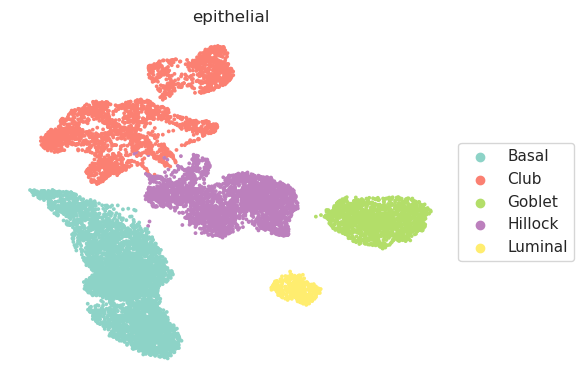

In [281]:
fig, ax = plt.subplots(figsize=(6, 4))  
sc.pl.umap(adata, color=["epithelial"], size=30, frameon=False,ax=ax, show=False , palette='Set3')
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("epithelial_GSE207422.png", dpi=300)
plt.show()

In [261]:
adata.write("epithelial_GSE207422.h5ad")

# Gene Signature Scoring Script

This script reads gene signatures from an Excel file, checks for missing genes in the dataset,
and scores available genes using Scanpy.


In [262]:
file_path = 'gene_signatures.xlsx'


gene_set_df = pd.read_excel(file_path)
print(gene_set_df.head())

missing_genes = {}
for module in gene_set_df.columns:
    missing_genes[module] = [gene for gene in gene_set_df[module] if gene not in adata.var_names]

# Step 2: Display missing genes for each module
for module, genes in missing_genes.items():
    if genes:
        print(f"Missing genes in module {module}: {genes}")

# Step 3: Filter the gene lists to include only genes available in `adata.var_names`
for module in gene_set_df.columns:
    valid_genes = [gene for gene in gene_set_df[module] if gene in adata.var_names]
    
    if valid_genes:
        print(f"Scoring genes for module {module}...")
        sc.tl.score_genes(adata, gene_list=valid_genes, score_name=f"score_{module}", random_state=123456)
    else:
        print(f"No valid genes for module {module} available in the data.")

# Step 4: Verify the scores were added
print(adata.obs.columns)

  Club Henry et al. 2018 Hillock Henry et al. 2018 scNMF Club  \
0                SCGB3A1                     KRT13       SLPI   
1                   LCN2                     S100P      WFDC2   
2                   PIGR                  APOBEC3A     CRABP2   
3                   PSCA                     GDF15       ASS1   
4                  OLFM4                      CSTB     S100A6   

  scNMF senescent epithelium scNMF interferon signaling epithelium  \
0                       SLPI                               HLA-DRA   
1                      WFDC2                                  CD74   
2                     CRABP2                              HLA-DRB1   
3                       ASS1                              HLA-DPA1   
4                     S100A6                              HLA-DQB1   

  PMN-MDSC activity MDSC Hirz 2023 MDSC Calcinotto 2018  \
0             RPL21          CEBPB                 IL4R   
1              XAF1           IL10             TNFRSF17   
2          

In [263]:
modules = [
    'score_Club Henry et al. 2018',
    'score_Hillock Henry et al. 2018',
    'score_scNMF Club',
    'score_scNMF senescent epithelium',
    'score_scNMF interferon signaling epithelium',
    'score_PMN-MDSC activity',
    'score_MDSC Hirz 2023',
    'score_MDSC Calcinotto 2018',
    'score_BPECT Luminal Identity',
    'score_BPECT Basal Identity',
    'score_BPECT Club Identity',
    'score_BPECT Hillock Identity',
    'score_BPECT Neuroendocrine Identity',
    'score_Tang et al. CRPC-AR',
    'score_Tang et al. CRPC-WNT',
    'score_Tang et al. CRPC-NE',
    'score_Tang et al. CRPC-SCL',
    'score_scNMF senescent epithelium',
    'score_Kiviaho et al. scNMF Club interferon',
    'score_Kiviaho et al. scNMF Club'
]

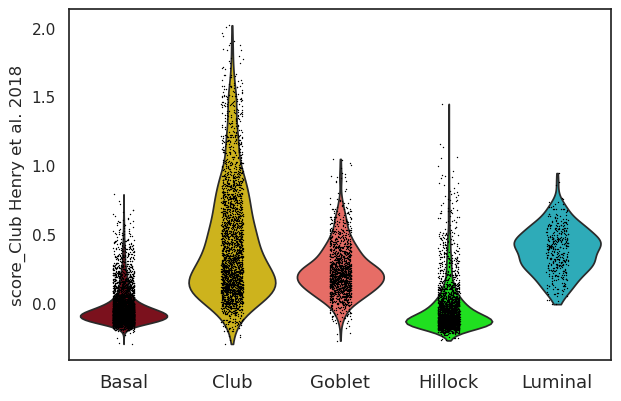

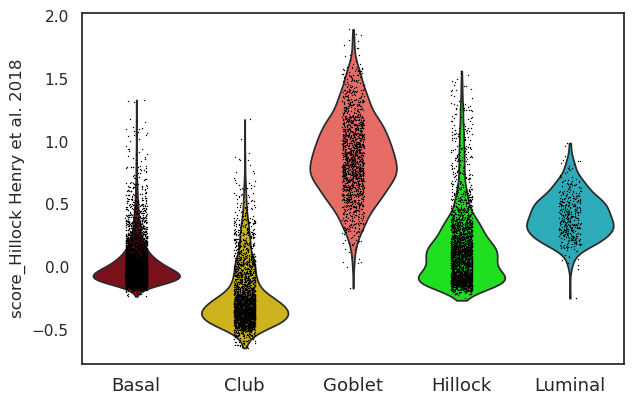

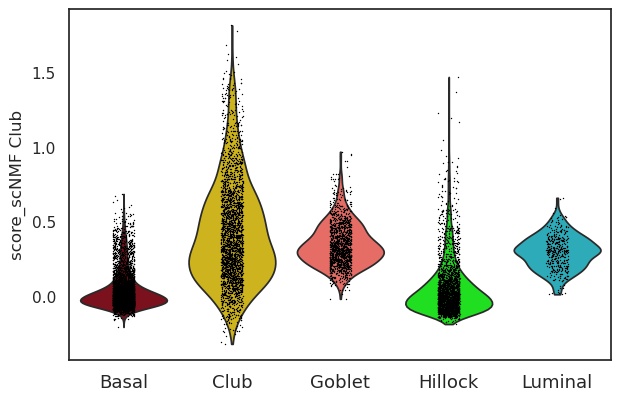

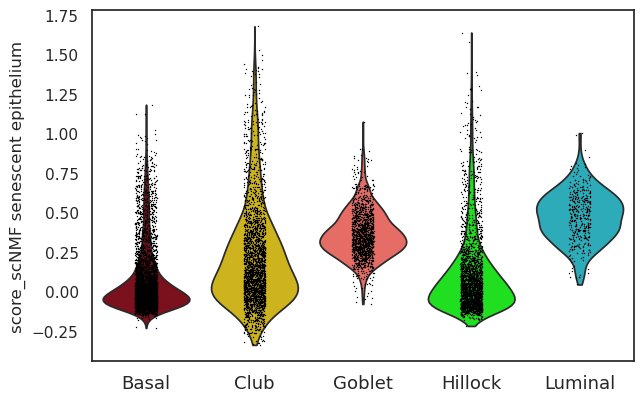

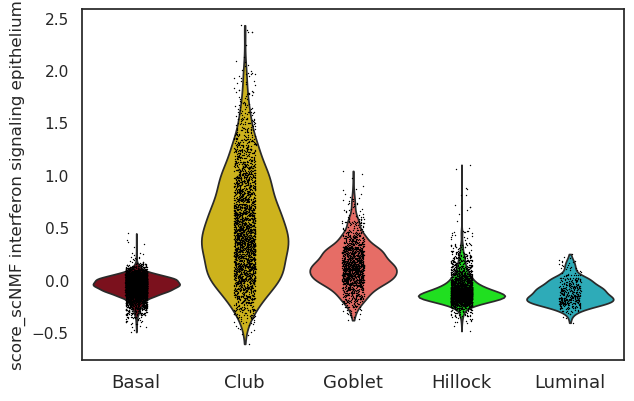

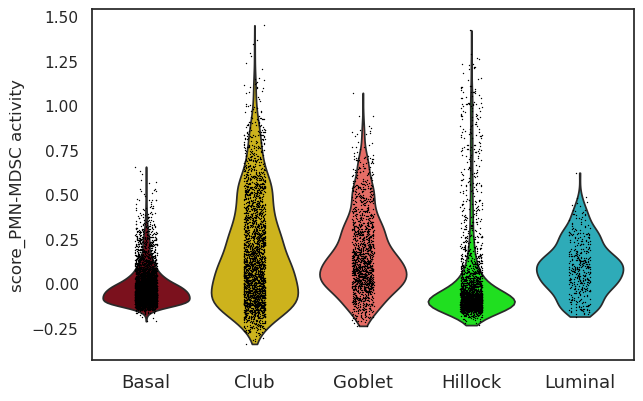

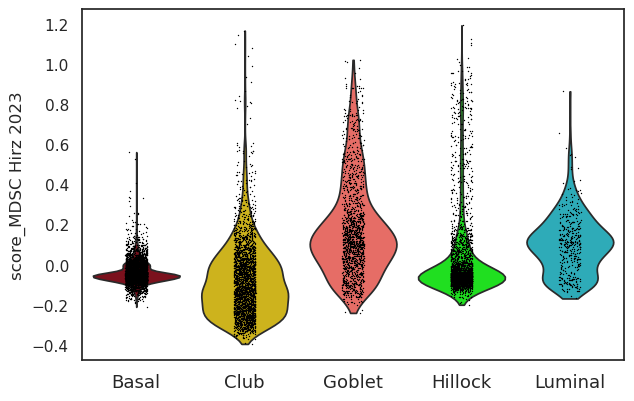

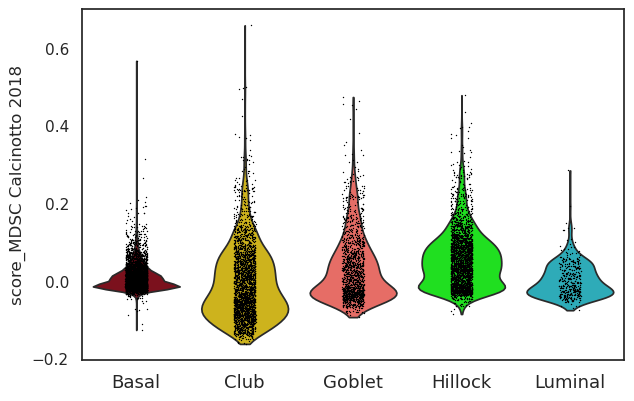

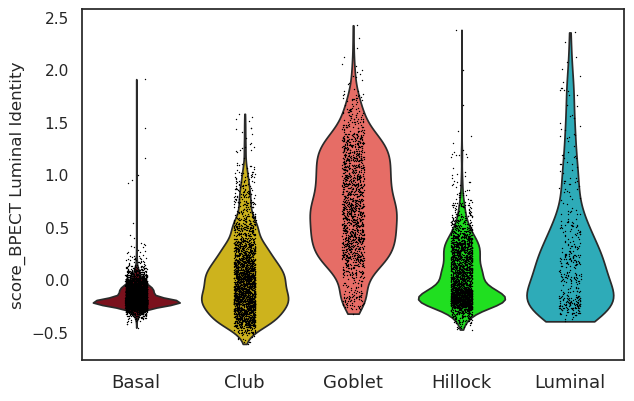

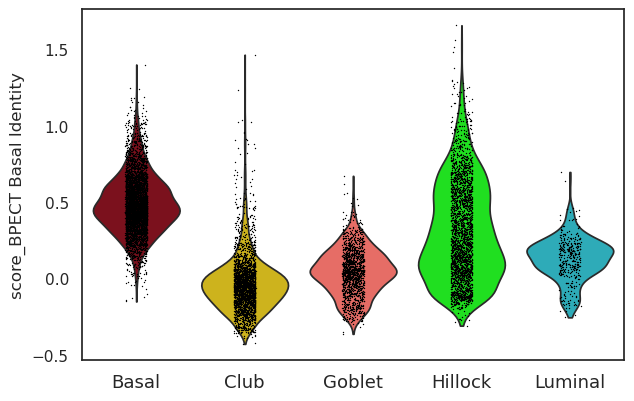

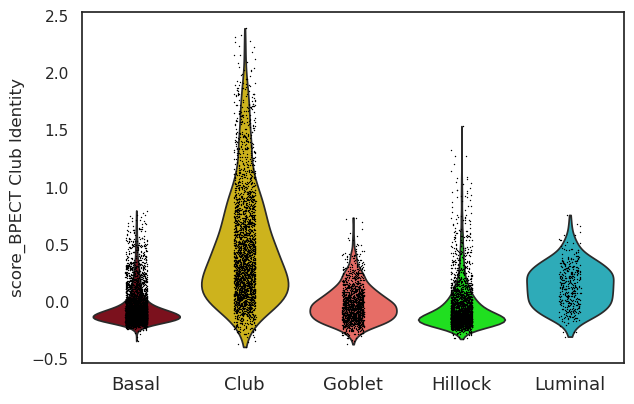

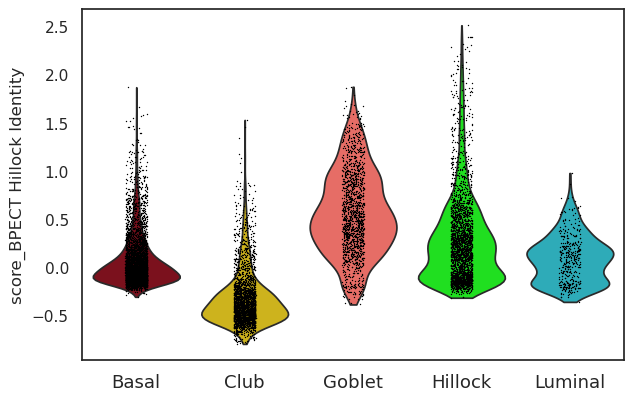

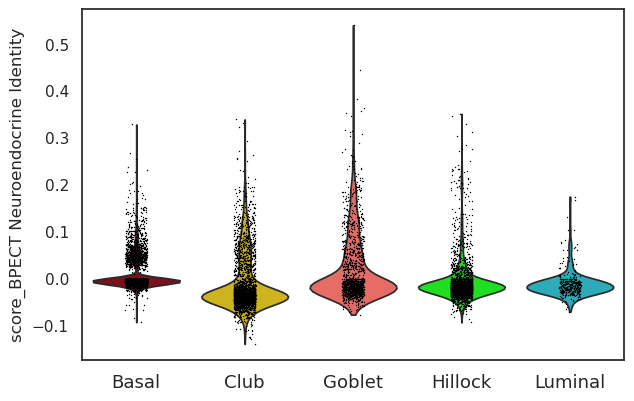

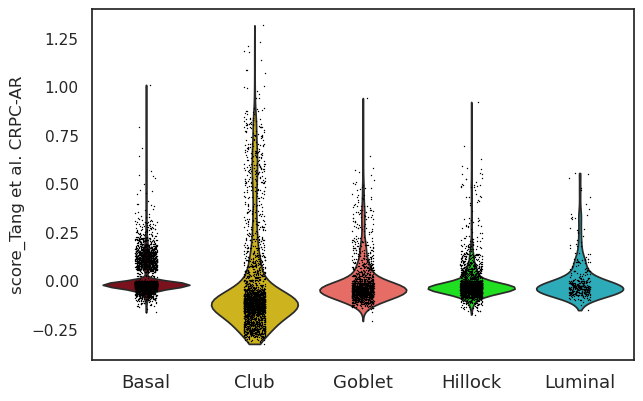

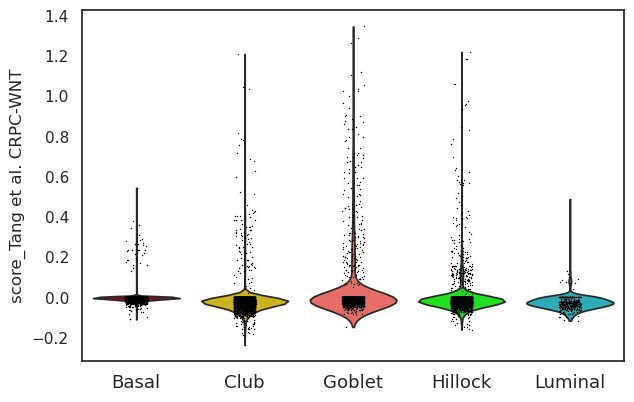

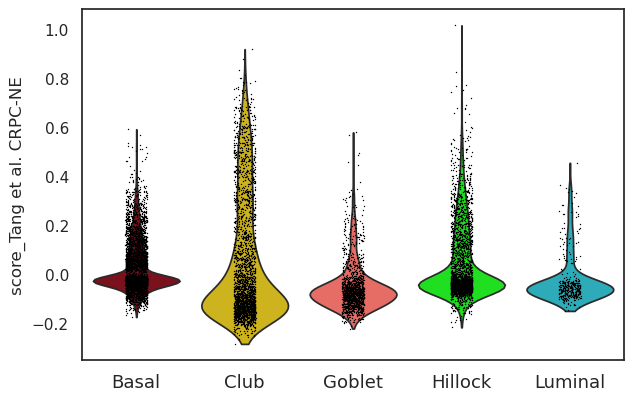

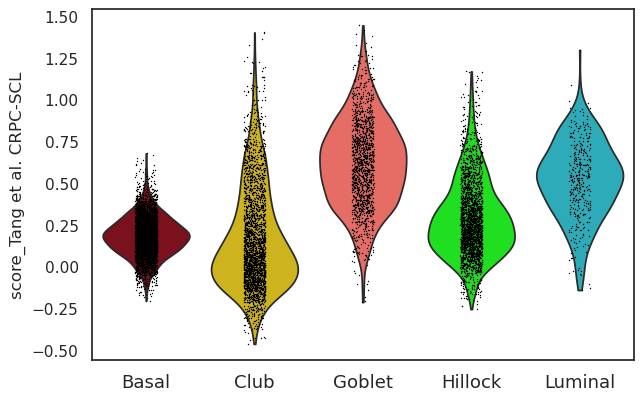

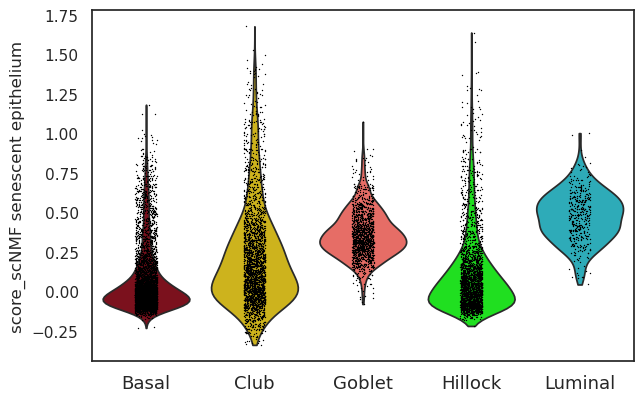

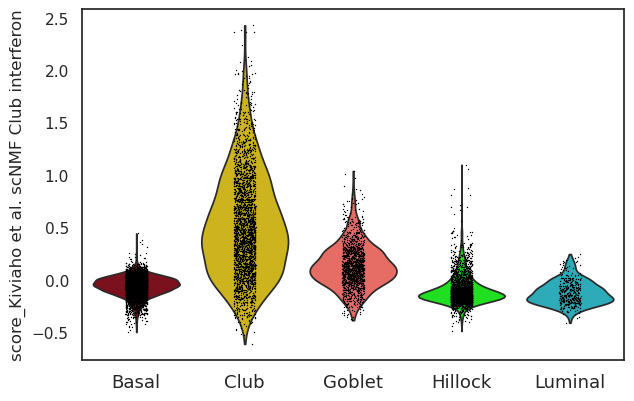

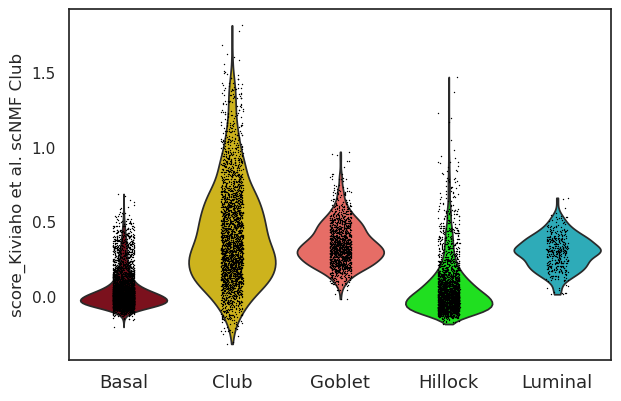

In [270]:
palette = {
    "Goblet": "#FC5A50",
    "Basal":  "#8C000F",    
    "Luminal": "#17becf",  
    "Club": "#EAC700",  
    "Hillock": "#00FF00", 
    "Prolif":  "#D81B60",  
}

for name in modules:
    sc.pl.violin(adata, keys=name, groupby='epithelial', show=False, palette= palette ,rotation=0)
    plt.ylabel(name, fontsize=12 )
    plt.xticks(fontsize=13)
    plt.tight_layout()
    plt.savefig(f"GSE207422_epi_{name.replace(' ', '_')}.png", dpi=300)
    plt.show()


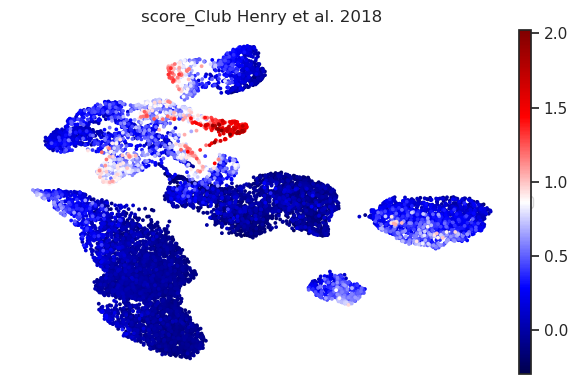

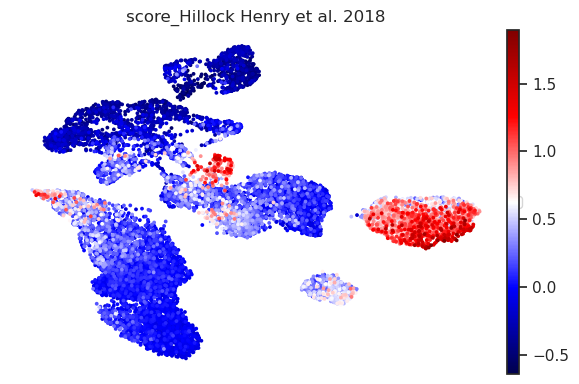

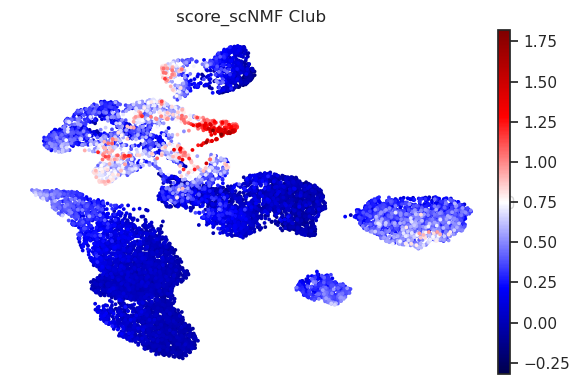

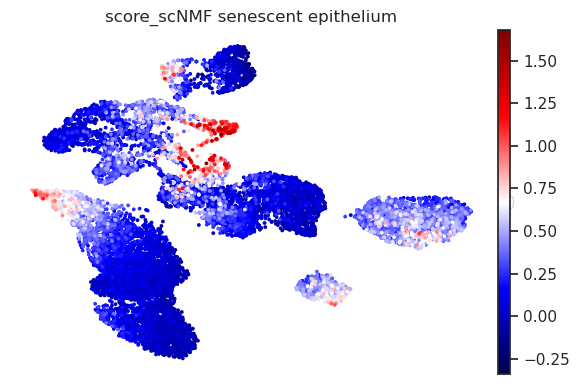

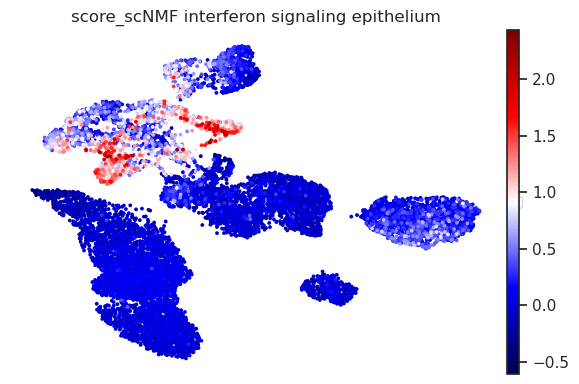

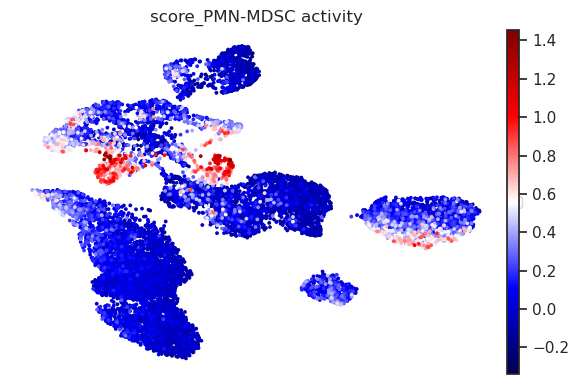

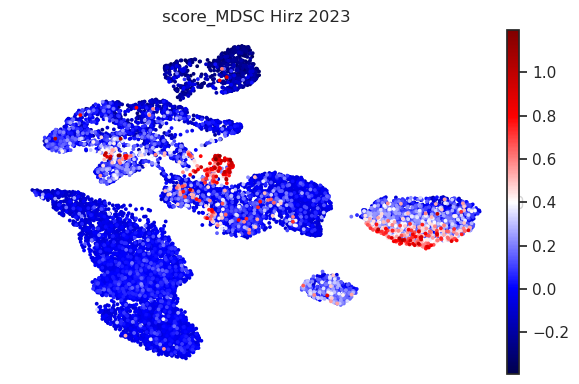

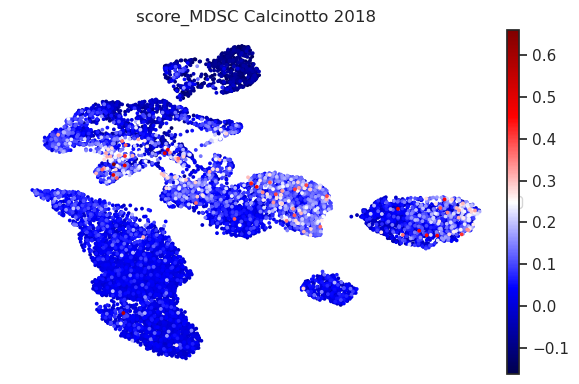

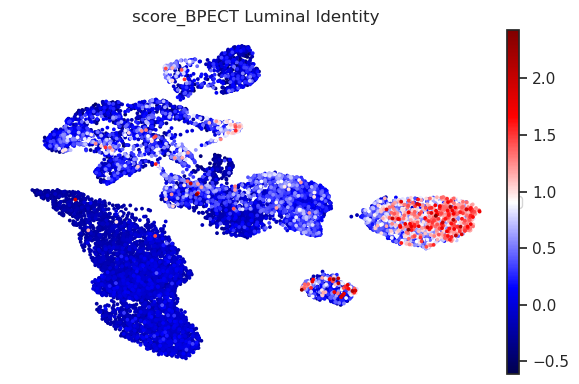

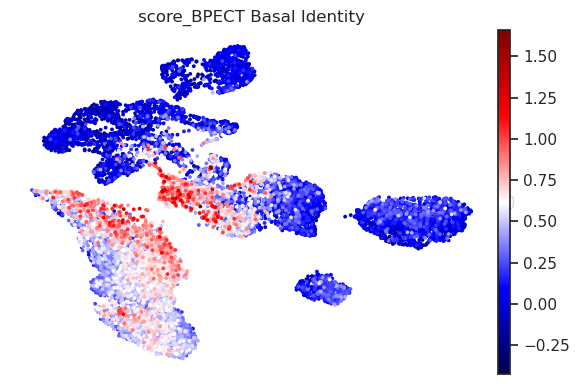

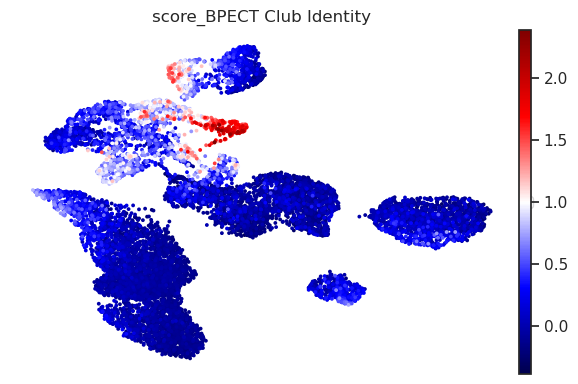

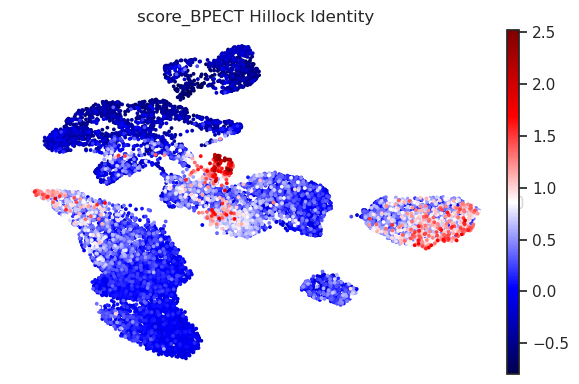

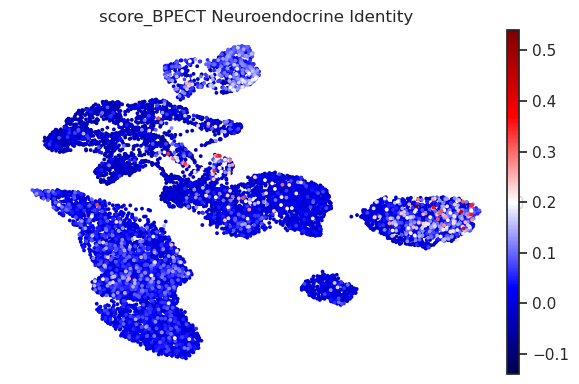

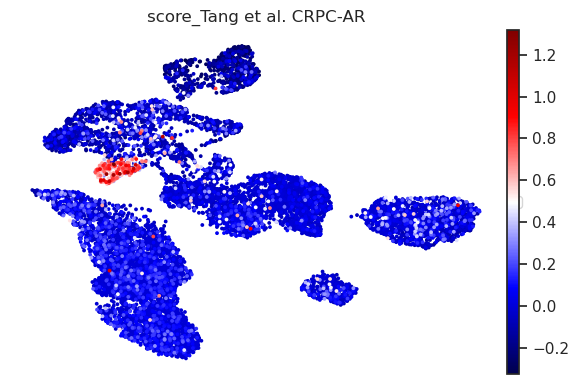

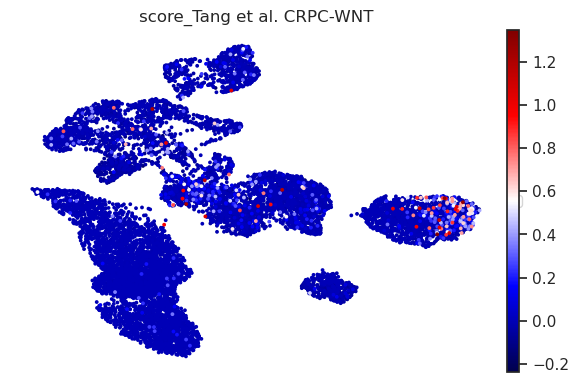

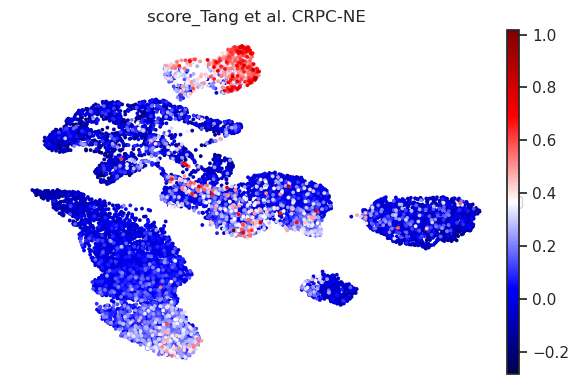

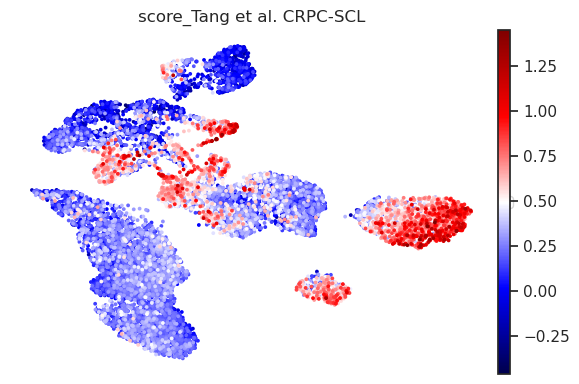

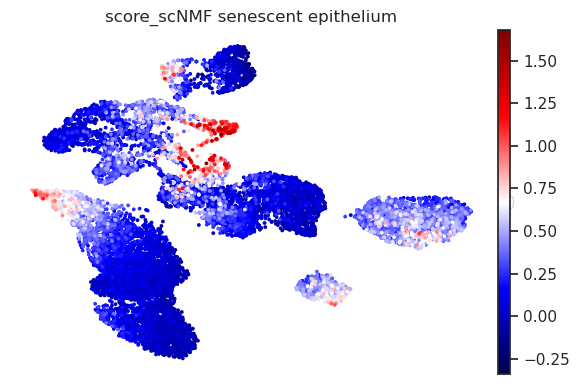

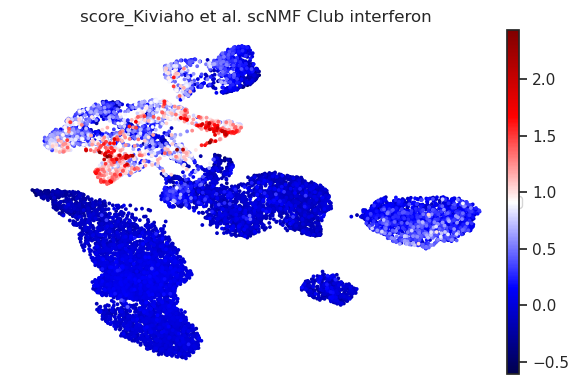

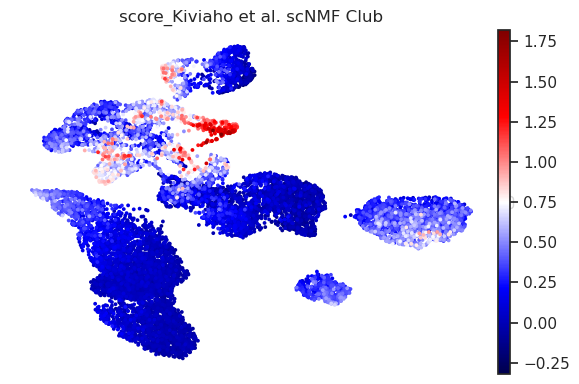

In [271]:
for name in modules:
    fig, ax = plt.subplots(figsize=(6, 4))  
    sc.pl.umap(adata, cmap= 'seismic', color=name, size=30, frameon=False, ax=ax, show=False)
    plt.ylabel(name, fontsize=12)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f"UMAP_GSE207422_{name.replace(' ', '_')}.png", dpi=300)
    plt.show()

In [272]:
adata.write('GSE207422_score_epi.h5ad')

In [273]:
pairs = [("MPR", "NMPR"), ("MPR", "pCR"), ("NMPR", "pCR")]
adata_df = adata.obs[['epithelial', 'Sample', 'Pathologic Response']].copy()
adata_df['Pathologic Response'] = adata_df['Pathologic Response'].replace({'pCR': 'MPR'})


club_cells_data = adata_df[adata_df['epithelial'] == 'Club']
club_cells_counts = club_cells_data.groupby(['Sample']).size()
total_counts = adata_df.groupby(['Sample']).size()
club_cells_pct = (club_cells_counts / total_counts) * 100

# Convert to DataFrame
plot_data = club_cells_pct.reset_index()
plot_data.columns = ['Sample', 'Percentage']
plot_data = plot_data.merge(adata_df[['Sample', 'Pathologic Response']].drop_duplicates(), on='Sample')
plot_data = plot_data[plot_data['Pathologic Response'] != "NE"]
p_values = []

# Perform pairwise Wilcoxon rank-sum tests
for g1, g2 in pairs:
    group1 = plot_data[plot_data['Pathologic Response'] == g1]['Percentage']
    group2 = plot_data[plot_data['Pathologic Response'] == g2]['Percentage']
    
    # Ensure both groups have data
    if len(group1) > 0 and len(group2) > 0:
        stat, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        p_values.append((g1, g2, p))


p_values_df = pd.DataFrame(p_values, columns=["Group1", "Group2", "P-value"])

# Multiple testing correction (Bonferroni method)
adjusted_p_values = multipletests(p_values_df["P-value"], method="bonferroni")[1]
p_values_df["Adjusted P-value"] = adjusted_p_values
print(plot_data)

print(p_values_df)

         Sample  Percentage Pathologic Response
1   BD_immune02  100.000000                NMPR
2   BD_immune03    6.600426                 MPR
3   BD_immune04  100.000000                NMPR
4   BD_immune05    0.271003                NMPR
5   BD_immune06   98.550725                 MPR
6   BD_immune07   10.424266                NMPR
7   BD_immune08   99.551570                NMPR
8   BD_immune09    0.000000                NMPR
9   BD_immune10    0.795756                NMPR
10  BD_immune11  100.000000                 MPR
11  BD_immune12   21.485944                NMPR
12  BD_immune13   97.297297                NMPR
13  BD_immune14   99.551570                 MPR
14  BD_immune15   99.832496                NMPR
  Group1 Group2   P-value  Adjusted P-value
0    MPR   NMPR  0.569479          0.569479


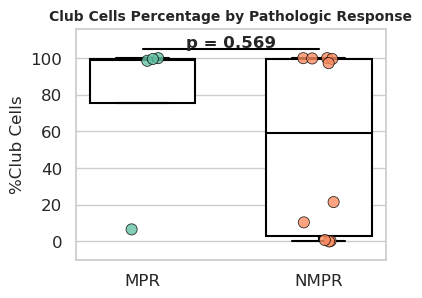

In [274]:
sns.set_style("whitegrid")
plt.figure(figsize=(4, 3))


plot_data['Pathologic Response'] = plot_data['Pathologic Response'].astype('category')
plot_data['Pathologic Response'] = plot_data['Pathologic Response'].cat.remove_unused_categories()
sample_palette = sns.color_palette("Set2", n_colors=len(plot_data['Pathologic Response'].cat.categories))


ax = sns.boxplot(data=plot_data, x='Pathologic Response', y='Percentage', 
                 width=0.6, linewidth=1.5, fliersize=0,  
                 boxprops=dict(facecolor='white', edgecolor='black'),
                 whiskerprops=dict(color="black"),
                 capprops=dict(color="black"),
                 medianprops=dict(color="black"),
                 zorder=1) 


sns.stripplot(data=plot_data, x='Pathologic Response', y='Percentage', 
              palette=sample_palette, jitter=True, size=8, alpha=0.8, edgecolor="black", linewidth=0.6, zorder=2)

# Add p-values above the boxes
y_max = plot_data["Percentage"].max() + 5  
for (g1, g2, p) in p_values:
    x1, x2 = list(plot_data["Pathologic Response"].unique()).index(g1), list(plot_data["Pathologic Response"].unique()).index(g2)
    plt.plot([x1, x2], [y_max, y_max], color="black", linewidth=1.5)
    plt.text((x1 + x2) / 2, y_max + 1, f"p = {p:.3f}", ha='center', fontsize=12, fontweight='bold')
    y_max += 6  


plt.title("Club Cells Percentage by Pathologic Response", fontsize=10, fontweight="bold")
plt.xlabel("")
plt.ylabel("%Club Cells", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-10, y_max + 5)  
plt.savefig("percentage_club_GSE207422.png", dpi=300)
plt.show()


In [275]:
pairs = [("MPR", "NMPR"), ("MPR", "pCR"), ("NMPR", "pCR")]
adata_df = adata.obs[['epithelial', 'Sample', 'Pathologic Response']].copy()
adata_df['Pathologic Response'] = adata_df['Pathologic Response'].replace({'pCR': 'MPR'})


club_cells_data = adata_df[adata_df['epithelial'] == 'Hillock']
club_cells_counts = club_cells_data.groupby(['Sample']).size()
total_counts = adata_df.groupby(['Sample']).size()
club_cells_pct = (club_cells_counts / total_counts) * 100

# Convert to DataFrame
plot_data = club_cells_pct.reset_index()
plot_data.columns = ['Sample', 'Percentage']
plot_data = plot_data.merge(adata_df[['Sample', 'Pathologic Response']].drop_duplicates(), on='Sample')
plot_data = plot_data[plot_data['Pathologic Response'] != "NE"]
p_values = []

# Perform pairwise Wilcoxon rank-sum tests
for g1, g2 in pairs:
    group1 = plot_data[plot_data['Pathologic Response'] == g1]['Percentage']
    group2 = plot_data[plot_data['Pathologic Response'] == g2]['Percentage']
    
    # Ensure both groups have data
    if len(group1) > 0 and len(group2) > 0:
        stat, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        p_values.append((g1, g2, p))

p_values_df = pd.DataFrame(p_values, columns=["Group1", "Group2", "P-value"])

# Multiple testing correction (Bonferroni method)
adjusted_p_values = multipletests(p_values_df["P-value"], method="bonferroni")[1]
p_values_df["Adjusted P-value"] = adjusted_p_values
print(p_values_df)

  Group1 Group2   P-value  Adjusted P-value
0    MPR   NMPR  0.829967          0.829967


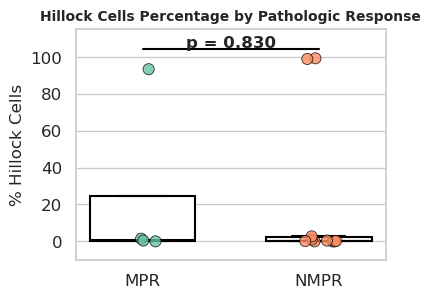

In [276]:
sns.set_style("whitegrid")
plt.figure(figsize=(4, 3))


plot_data['Pathologic Response'] = plot_data['Pathologic Response'].astype('category')
plot_data['Pathologic Response'] = plot_data['Pathologic Response'].cat.remove_unused_categories()
sample_palette = sns.color_palette("Set2", n_colors=len(plot_data['Pathologic Response'].cat.categories))


ax = sns.boxplot(data=plot_data, x='Pathologic Response', y='Percentage', 
                 width=0.6, linewidth=1.5, fliersize=0,  
                 boxprops=dict(facecolor='white', edgecolor='black'),
                 whiskerprops=dict(color="black"),
                 capprops=dict(color="black"),
                 medianprops=dict(color="black"),
                 zorder=1) 


sns.stripplot(data=plot_data, x='Pathologic Response', y='Percentage', 
              palette=sample_palette, jitter=True, size=8, alpha=0.8, edgecolor="black", linewidth=0.6, zorder=2)
# Add p-values above the boxes
y_max = plot_data["Percentage"].max() + 5  
for (g1, g2, p) in p_values:
    x1, x2 = list(plot_data["Pathologic Response"].unique()).index(g1), list(plot_data["Pathologic Response"].unique()).index(g2)
    plt.plot([x1, x2], [y_max, y_max], color="black", linewidth=1.5)
    plt.text((x1 + x2) / 2, y_max + 1, f"p = {p:.3f}", ha='center', fontsize=12, fontweight='bold')
    y_max += 6  


plt.title("Hillock Cells Percentage by Pathologic Response", fontsize=10, fontweight="bold")
plt.xlabel("")
plt.ylabel("% Hillock Cells", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-10, y_max + 5)  
plt.savefig("percentage_hillock_GSE207422.png", dpi=300)
plt.show()

In [277]:
pairs = [("Toripalimab", "Camrelizumab"), ("Toripalimab", "Sintilimab"), ("Camrelizumab", "Sintilimab")]
adata_df = adata.obs[['epithelial', 'Sample', 'PD1 Antibody']].copy()

club_cells_data = adata_df[adata_df['epithelial'] == 'Club']
club_cells_counts = club_cells_data.groupby(['Sample']).size()
total_counts = adata_df.groupby(['Sample']).size()
club_cells_pct = (club_cells_counts / total_counts) * 100

# Convert to DataFrame
plot_data = club_cells_pct.reset_index()
plot_data.columns = ['Sample', 'Percentage']
plot_data = plot_data.merge(adata_df[['Sample', 'PD1 Antibody']].drop_duplicates(), on='Sample')
plot_data = plot_data[plot_data['PD1 Antibody'] != "NE"]
p_values = []

# Perform pairwise Wilcoxon rank-sum tests
for g1, g2 in pairs:
    group1 = plot_data[plot_data['PD1 Antibody'] == g1]['Percentage']
    group2 = plot_data[plot_data['PD1 Antibody'] == g2]['Percentage']
    
    # Ensure both groups have data
    if len(group1) > 0 and len(group2) > 0:
        stat, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        p_values.append((g1, g2, p))

p_values_df = pd.DataFrame(p_values, columns=["Group1", "Group2", "P-value"])

# Multiple testing correction (Bonferroni method)
adjusted_p_values = multipletests(p_values_df["P-value"], method="bonferroni")[1]
p_values_df["Adjusted P-value"] = adjusted_p_values
print(p_values_df)

         Group1        Group2   P-value  Adjusted P-value
0   Toripalimab  Camrelizumab  0.660620               1.0
1   Toripalimab    Sintilimab  0.897879               1.0
2  Camrelizumab    Sintilimab  0.826238               1.0


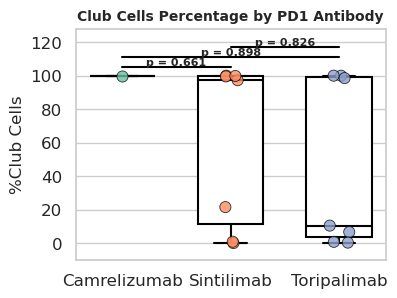

In [278]:
sns.set_style("whitegrid")
plt.figure(figsize=(4, 3))


plot_data['PD1 Antibody'] = plot_data['PD1 Antibody'].astype('category')
plot_data['PD1 Antibody'] = plot_data['PD1 Antibody'].cat.remove_unused_categories()
sample_palette = sns.color_palette("Set2", n_colors=len(plot_data['PD1 Antibody'].cat.categories))


ax = sns.boxplot(data=plot_data, x='PD1 Antibody', y='Percentage', 
                 width=0.6, linewidth=1.5, fliersize=0,  
                 boxprops=dict(facecolor='white', edgecolor='black'),
                 whiskerprops=dict(color="black"),
                 capprops=dict(color="black"),
                 medianprops=dict(color="black"),
                 zorder=1) 


sns.stripplot(data=plot_data, x='PD1 Antibody', y='Percentage', 
              palette=sample_palette, jitter=True, size=8, alpha=0.8, edgecolor="black", linewidth=0.6, zorder=2)

# Add p-values above the boxes
y_max = plot_data["Percentage"].max() + 5  
for (g1, g2, p) in p_values:
    x1, x2 = list(plot_data["PD1 Antibody"].unique()).index(g1), list(plot_data["PD1 Antibody"].unique()).index(g2)
    plt.plot([x1, x2], [y_max, y_max], color="black", linewidth=1.5)
    plt.text((x1 + x2) / 2, y_max + 1, f"p = {p:.3f}", ha='center', fontsize=8, fontweight='bold')
    y_max += 6  


plt.title("Club Cells Percentage by PD1 Antibody", fontsize=10, fontweight="bold")
plt.xlabel("")
plt.ylabel("%Club Cells", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-10, y_max + 5)  
plt.savefig("percentage_club_PD1 Antibody_GSE207422.png", dpi=300)
plt.show()
